In [1]:
# !pip install nilearn
# !pip install matplotlib
# !pip install monai
# !pip install tensorboard
# !pip install comet_ml

In [2]:
import torch
from torch import nn
import os

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

from pathlib import Path
from nilearn import image
import nilearn
from nilearn import plotting

import monai
from monai.data import DataLoader, ImageDataset, CacheDataset
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    CropForegroundd,
    NormalizeIntensityd,
    Resized,
    RandGaussianSmoothd,
    RandAffined,
    RandFlipd,
)
from monai.networks.blocks import ResidualUnit,Convolution

from torch.utils.tensorboard import SummaryWriter
from comet_ml import Experiment

import warnings
warnings.filterwarnings("ignore")

In [3]:
# костыль для чтения MGZ

from typing import List, Sequence, Union

import nibabel as nib
from monai.data.image_reader import NibabelReader, has_nib
from monai.data.utils import (correct_nifti_header_if_necessary, is_supported_format)
from monai.transforms import LoadImage
from monai.utils import ensure_tuple
from nibabel.nifti1 import Nifti1Image


def verify_suffix(self, filename: Union[Sequence[str], str]) -> bool:
    """
    Verify whether the specified file or files format is supported by Nibabel reader.

    Args:
        filename: file name or a list of file names to read.
            if a list of files, verify all the suffixes.

    """
    suffixes: Sequence[str] = ["nii", "nii.gz", "mgz"]  # <- Added 'mgz' here
    return has_nib and is_supported_format(filename, suffixes)


def read(self, data: Union[Sequence[str], str], **kwargs):
    """
        Read image data from specified file or files.
        Note that the returned object is Nibabel image object or list of Nibabel image objects.

        Args:
            data: file name or a list of file names to read.
            kwargs: additional args for `nibabel.load` API, will override `self.kwargs` for existing keys.
                More details about available args:
                https://github.com/nipy/nibabel/blob/master/nibabel/loadsave.py

        """
    img_: List[Nifti1Image] = []

    filenames: Sequence[str] = ensure_tuple(data)
    kwargs_ = self.kwargs.copy()
    kwargs_.update(kwargs)
    for name in filenames:
        img = nib.load(name, **kwargs_)
        if not isinstance(img, Nifti1Image):   # <- added this line
            img = Nifti1Image.from_image(img)  # <- added this line
        img = correct_nifti_header_if_necessary(img)
        img_.append(img)
    return img_ if len(filenames) > 1 else img_[0]


NibabelReader.verify_suffix = verify_suffix
NibabelReader.read = read

#LoadImage()(r'/data/mnt/data/NFS/Uranus/schizo_datasets/COBRE/COBRE_freesurfer/A00000300/mri/brain.mgz')

In [4]:
!nvidia-smi

Tue Oct 25 17:00:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 20%   27C    P8     8W / 250W |   3201MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# preprocessing

In [6]:
import os

AUX_DATA_ROOT = '/data/mnt/data/NFS/Uranus/schizo_datasets/COBRE'

subject_path = os.path.join(AUX_DATA_ROOT, 'COBRE_preproc/t1_linear_bfc/sub-A00000300/Warped.nii.gz')

In [7]:
fmri_file = image.load_img(subject_path)

In [8]:
fmri_file.shape

(260, 311, 260)

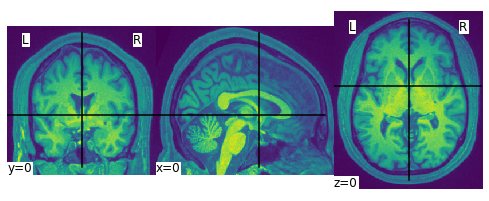

In [9]:
nilearn.plotting.plot_img(fmri_file, cut_coords=(0,0,0))

## reading data

In [10]:
labels = pd.read_csv('data/labels.csv')

okay_target = ['No_Known_Disorder', 'Schizophrenia_Strict']
labels = labels.query('target in @okay_target')
labels['bin_target'] = labels['target'].apply(lambda x: 0 if x == 'No_Known_Disorder' else 1)

labels_dict = dict(zip(labels['ID'].values.tolist(), labels['bin_target'].values.tolist()))

In [11]:
data = 'raw' # or 'prepr' or 'raw' 

images =[]
labels =[]
for id_, label in labels_dict.items():
    #print(id_)
    #subject_path = os.path.join(AUX_DATA_ROOT, f'COBRE_preproc/t1_linear_bfc/sub-{id_}/Warped.nii.gz')
    if data == 'raw':
        subject_path = os.path.join(AUX_DATA_ROOT, f'COBRE_freesurfer/{id_}/mri/brain.mgz')
    else:
        subject_path = os.path.join(AUX_DATA_ROOT, f'COBRE_preproc/t1_linear_bfc/sub-{id_}/Warped.nii.gz')
        
    brain_path = Path(subject_path)

    if brain_path.exists():
        images.append(brain_path)
        labels.append(label)

In [12]:
# Define transforms
batch_size = 8
image_size = 64

data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(images, labels)]

train_transforms = Compose([LoadImaged(keys='image'),
                            EnsureChannelFirstd(keys='image'),
                            CropForegroundd(keys='image', source_key='image', select_fn=lambda x: x > 0, margin=0),
                            NormalizeIntensityd(keys='image',), 
                            Resized(keys='image', spatial_size=(image_size, image_size, image_size)),
#                             RandGaussianSmoothd(keys='image'),
#                             RandAffined(keys='image'),
#                             RandFlipd(keys='image'),
                           ])

val_transforms = Compose([LoadImaged(keys='image'),
                          EnsureChannelFirstd(keys='image'),
                          CropForegroundd(keys='image', source_key='image', select_fn=lambda x: x > 0, margin=0),
                          NormalizeIntensityd(keys='image',), 
                          Resized(keys='image', spatial_size=(image_size, image_size, image_size)),
                         ])


# train_transforms = Compose([  #EnsureChannelFirst(),
#                             CropForeground(select_fn=lambda x: x > 0, margin=0),
#                             NormalizeIntensity(), 
#                             Resize(spatial_size=(image_size, image_size, image_size))])

# val_transforms = Compose([#EnsureChannelFirst(),
#                           CropForeground(select_fn=lambda x: x > 0, margin=0),
#                           NormalizeIntensity(), 
#                           Resize(spatial_size=(image_size, image_size, image_size))])



# # Define nifti dataset, data loader
# #check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
# check_ds = CacheDataset(data=data_dicts, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

# im, label = monai.utils.misc.first(check_loader)
# print(type(im), im.shape, label, label.shape)

# create a training data loader
#train_ds = ImageDataset(image_files=images[:-30], labels=labels[:-30], transform=train_transforms)
train_ds = CacheDataset(data=data_dicts[:-30], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,pin_memory=pin_memory)

# create a validation data loader
#val_ds = ImageDataset(image_files=images[-30:], labels=labels[-30:], transform=val_transforms)
val_ds = CacheDataset(data=data_dicts[-30:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=pin_memory)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.31it/s]


In [13]:
data_dicts[0]['image']

PosixPath('/data/mnt/data/NFS/Uranus/schizo_datasets/COBRE/COBRE_freesurfer/A00007409/mri/brain.mgz')

In [14]:
myit = iter(train_loader)
batch_ = next(myit)
batch_['image'].size()

(8, 1, 64, 64, 64)

## model

In [15]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConvEncoder(nn.Module):
    def __init__(self, in_channels=1,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="prelu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 is_rcnn=False):
        super(ConvEncoder, self).__init__()
        self.is_rcnn =is_rcnn
        convs =[]
        for out_channels in out_channels_list:
            if network_type =="Residual":
                conv = ResidualUnit(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            else:
                conv = Convolution(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            in_channels =out_channels
            convs.append(conv)
            
        self.conv_layer =nn.Sequential(*convs)
        input_shape = np.array(input_shape)
        self.n_flatten_units = int(np.prod(input_shape // (2 ** len(out_channels_list))) * out_channels)
        self.faltten = Flatten()
        
    def forward(self, x):
        if self.is_rcnn:
            n_objects, seq_length = x.size()[0:2]
            x = x.reshape([n_objects * seq_length] + list(x.size()[2:]))
            x = torch.unsqueeze(x, axis=1)
            x = self.conv_layer(x)
            x =self.faltten(x)
            x = x.reshape([n_objects, seq_length, -1])
        else:
            x = self.conv_layer(x)
            x =self.faltten(x)
        return x        

In [16]:
class FMRINET(nn.Module):
    def __init__(self, in_channels=10,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="prelu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 n_outputs =2,
                 n_fc_units=128,
                 hidden_size=128,
                 dropout =0.2,
                 is_rcnn=False):
        super(FMRINET, self).__init__()
        self.is_rcnn=is_rcnn
        if self.is_rcnn:
            self.cnn =ConvEncoder(in_channels=1,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=True)
            self.gru =ClfGRU(self.cnn.n_flatten_units, 
                             in_channels,hidden_size=hidden_size)
            self.fc =nn.Sequential(
                               nn.Dropout(dropout),    
                               nn.Linear(self.gru.gru_out_size, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
            
        else:
            self.cnn =ConvEncoder(in_channels=in_channels,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=False)
            self.fc =nn.Sequential(
                               nn.Dropout(dropout),
                               nn.Linear(self.cnn.n_flatten_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
        
    def forward(self,x):
        if self.is_rcnn:
            x =self.cnn(x)
            x =self.gru(x)
            x =self.fc(x)
        else:
            x =self.cnn(x)
            x =self.fc(x)
        return x    

In [17]:
lr = 0.0001
dropout = 0.5
weight_decay = 0.001
exp_name = f'MRI_{data}'

model =FMRINET( out_channels_list=[8, 16, 32, 64, 128],
                 in_channels=1,
                 n_fc_units=64,
                 hidden_size=64,
                 input_shape=(image_size, image_size, image_size),
                 dropout=dropout, is_rcnn=False,)

model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


# Create an experiment with your api key
experiment = Experiment(
    api_key="W4Exl5JlKMoVHRelfS04Tc0Lg",
    project_name="mri-cobre",
    workspace="petrsokerin",
)

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": lr,
    "weight_decay": weight_decay,
    "batch_size": batch_size,
    "dropout": dropout,
}
experiment.log_parameters(hyper_params)
experiment.set_name(exp_name)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: tensorboard, sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/workspace' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/petrsokerin/mri-cobre/a309c44f641440b58d06f853c6d407ab



In [18]:
# start a typical PyTorch training
val_interval = 1
best_metric = -1
best_metric_epoch = -1  
epoch_loss_values = []
metric_values = []
#writer = SummaryWriter()
max_epochs = 40

for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    num_correct = 0.0
    metric_count = 0
    
    print('training')
    for batch_data in tqdm(train_loader):
        
        #print(batch_data)
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        
        #value = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
        value = torch.eq(outputs.argmax(dim=1), labels)
        metric_count += len(value)
        num_correct += value.sum().item()
                
        # print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        #writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        experiment.log_metric("train_loss", loss.item(), epoch=epoch, step=epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    metric = num_correct / metric_count
    experiment.log_metric("train_accuracy", metric, epoch=epoch)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    print(f"Current epoch: {epoch+1} current train accuracy: {metric:.4f} ")
    
    
    if (epoch + 1) % val_interval == 0:
        print('validation')
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in tqdm(val_loader):
                    val_images, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                    val_outputs = model(val_images)
                    #value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                    metric_count += len(value)
                    num_correct += value.sum().item()

            metric = num_correct / metric_count
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "MRI_best.pth")
                print("saved new best metric model")

            print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
            print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            #writer.add_scalar("val_accuracy", metric, epoch + 1)
            experiment.log_metric("val_accuracy", metric, epoch=epoch)
            
print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

  0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 1 average loss: 0.6834
Current epoch: 1 current train accuracy: 0.5268 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

saved new best metric model
Current epoch: 1 current accuracy: 0.6333 
Best accuracy: 0.6333 at epoch 1
----------
epoch 2/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 2 average loss: 0.6917
Current epoch: 2 current train accuracy: 0.5179 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 2 current accuracy: 0.6333 
Best accuracy: 0.6333 at epoch 1
----------
epoch 3/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 3 average loss: 0.6908
Current epoch: 3 current train accuracy: 0.5089 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 3 current accuracy: 0.6000 
Best accuracy: 0.6333 at epoch 1
----------
epoch 4/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 4 average loss: 0.6861
Current epoch: 4 current train accuracy: 0.5268 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

saved new best metric model
Current epoch: 4 current accuracy: 0.7000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 5/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 5 average loss: 0.6707
Current epoch: 5 current train accuracy: 0.6429 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 5 current accuracy: 0.5667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 6/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 6 average loss: 0.6679
Current epoch: 6 current train accuracy: 0.5982 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 6 current accuracy: 0.6333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 7/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 7 average loss: 0.6637
Current epoch: 7 current train accuracy: 0.6607 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 7 current accuracy: 0.3333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 8/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 8 average loss: 0.6746
Current epoch: 8 current train accuracy: 0.5714 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 8 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 9/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 9 average loss: 0.6397
Current epoch: 9 current train accuracy: 0.6339 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 9 current accuracy: 0.6000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 10/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 10 average loss: 0.6281
Current epoch: 10 current train accuracy: 0.6696 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 10 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 11/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 11 average loss: 0.6429
Current epoch: 11 current train accuracy: 0.6071 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 11 current accuracy: 0.4667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 12/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 12 average loss: 0.5883
Current epoch: 12 current train accuracy: 0.7321 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 12 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 13/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 13 average loss: 0.5663
Current epoch: 13 current train accuracy: 0.7500 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 13 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 14/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 14 average loss: 0.5690
Current epoch: 14 current train accuracy: 0.7143 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 14 current accuracy: 0.6333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 15/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 15 average loss: 0.5334
Current epoch: 15 current train accuracy: 0.7857 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 15 current accuracy: 0.4000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 16/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 16 average loss: 0.5006
Current epoch: 16 current train accuracy: 0.7679 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 16 current accuracy: 0.5333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 17/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 17 average loss: 0.4774
Current epoch: 17 current train accuracy: 0.8214 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 17 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 18/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 18 average loss: 0.4803
Current epoch: 18 current train accuracy: 0.7768 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 18 current accuracy: 0.3667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 19/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 19 average loss: 0.4444
Current epoch: 19 current train accuracy: 0.8214 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 19 current accuracy: 0.6333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 20/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 20 average loss: 0.4167
Current epoch: 20 current train accuracy: 0.8571 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 20 current accuracy: 0.5000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 21/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 21 average loss: 0.3764
Current epoch: 21 current train accuracy: 0.8929 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 21 current accuracy: 0.5333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 22/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 22 average loss: 0.3619
Current epoch: 22 current train accuracy: 0.8750 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 22 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 23/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 23 average loss: 0.2968
Current epoch: 23 current train accuracy: 0.9286 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 23 current accuracy: 0.7000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 24/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 24 average loss: 0.2894
Current epoch: 24 current train accuracy: 0.9286 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 24 current accuracy: 0.5333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 25/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 25 average loss: 0.2339
Current epoch: 25 current train accuracy: 0.9643 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 25 current accuracy: 0.7000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 26/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 26 average loss: 0.1795
Current epoch: 26 current train accuracy: 0.9821 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 26 current accuracy: 0.5667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 27/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 27 average loss: 0.2443
Current epoch: 27 current train accuracy: 0.9375 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 27 current accuracy: 0.3667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 28/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 28 average loss: 0.1853
Current epoch: 28 current train accuracy: 0.9554 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 28 current accuracy: 0.6000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 29/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 29 average loss: 0.1281
Current epoch: 29 current train accuracy: 1.0000 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 29 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 30/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 30 average loss: 0.1230
Current epoch: 30 current train accuracy: 0.9911 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 30 current accuracy: 0.4667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 31/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 31 average loss: 0.1097
Current epoch: 31 current train accuracy: 0.9821 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 31 current accuracy: 0.7000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 32/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 32 average loss: 0.1201
Current epoch: 32 current train accuracy: 0.9732 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 32 current accuracy: 0.7000 
Best accuracy: 0.7000 at epoch 4
----------
epoch 33/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 33 average loss: 0.0882
Current epoch: 33 current train accuracy: 0.9821 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 33 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 34/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 34 average loss: 0.0874
Current epoch: 34 current train accuracy: 0.9911 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 34 current accuracy: 0.5333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 35/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 35 average loss: 0.0645
Current epoch: 35 current train accuracy: 1.0000 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 35 current accuracy: 0.3333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 36/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 36 average loss: 0.0841
Current epoch: 36 current train accuracy: 1.0000 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 36 current accuracy: 0.3667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 37/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 37 average loss: 0.0464
Current epoch: 37 current train accuracy: 1.0000 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 37 current accuracy: 0.4333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 38/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 38 average loss: 0.0497
Current epoch: 38 current train accuracy: 1.0000 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 38 current accuracy: 0.6333 
Best accuracy: 0.7000 at epoch 4
----------
epoch 39/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 39 average loss: 0.0609
Current epoch: 39 current train accuracy: 1.0000 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 39 current accuracy: 0.6667 
Best accuracy: 0.7000 at epoch 4
----------
epoch 40/40
training


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 40 average loss: 0.0337
Current epoch: 40 current train accuracy: 1.0000 
validation


  0%|          | 0/4 [00:00<?, ?it/s]

Current epoch: 40 current accuracy: 0.6000 
Best accuracy: 0.7000 at epoch 4
Training completed, best_metric: 0.7000 at epoch: 4


NameError: name 'writer' is not defined